In [1]:
# library imports
import os
import random
import math
from datetime import datetime
from collections import Counter
import pandas as pd
import numpy as np

import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

%reload_ext autoreload
%autoreload 2
%matplotlib inline


In [2]:
images_path = Path('./road_signs/images')
anno_path = Path('./road_signs/annotations')

In [3]:
def filelist(root, file_type):
    """Returns a fully-qualified list of filenames under root directory"""
    return [os.path.join(directory_path, f) for directory_path, directory_name, 
            files in os.walk(root) for f in files if f.endswith(file_type)]

def generate_train_df (anno_path):
    annotations = filelist(anno_path, '.xml')
    anno_list = []
    for anno_path in annotations:
        root = ET.parse(anno_path).getroot()
        anno = {}
        anno['filename'] = Path(str(images_path) + '/'+ root.find("./filename").text)
        anno['width'] = root.find("./size/width").text
        anno['height'] = root.find("./size/height").text
        anno['class'] = root.find("./object/name").text
        anno['xmin'] = int(root.find("./object/bndbox/xmin").text)
        anno['ymin'] = int(root.find("./object/bndbox/ymin").text)
        anno['xmax'] = int(root.find("./object/bndbox/xmax").text)
        anno['ymax'] = int(root.find("./object/bndbox/ymax").text)
        anno_list.append(anno)
    return pd.DataFrame(anno_list)

df_train = generate_train_df(anno_path)


In [4]:
# label encode target
class_dict = {'speedlimit': 0, 'stop': 1, 'crosswalk': 2, 'trafficlight': 3}
df_train['class'] = df_train['class'].apply(lambda x:  class_dict[x])

In [5]:
print(df_train.shape)
df_train.head()


(877, 8)


,filename,width,height,class,xmin,ymin,xmax,ymax
0,road_signs/images/road712.png,300,400,0,98,140,139,182
1,road_signs/images/road706.png,300,400,0,136,92,177,135
2,road_signs/images/road289.png,300,400,1,61,140,146,227
3,road_signs/images/road538.png,300,400,0,115,169,149,205
4,road_signs/images/road510.png,300,400,0,89,201,133,245


# Resizing images and bounding boxes

In [6]:
# Reading an image
def read_image(path):
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)

def create_mask(bb, x):
    """Creates a mask for the bounding box of same shape as image"""
    rows,cols,*_ = x.shape
    Y = np.zeros((rows, cols))
    bb = bb.astype(np.int32)
    Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return Y

def mask_to_bb(Y):
    """Convert mask Y to a bounding box, assumes 0 as background nonzero object"""
    cols, rows = np.nonzero(Y)
    if len(cols)==0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

def create_bb_array(x):
    """Generates bounding box array from a train_df row"""
    return np.array([x[5],x[4],x[7],x[6]])

In [7]:
def resize_image_bb(read_path,write_path,bb,sz):
    """Resize an image and its bounding box and write image to new path"""
    im = read_image(read_path)
    im_resized = cv2.resize(im, (int(1.49*sz), sz))
    Y_resized = cv2.resize(create_mask(bb, im), (int(1.49*sz), sz))
    new_path = str(write_path/read_path.parts[-1])
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    
    return new_path, mask_to_bb(Y_resized)

In [8]:
# Populating Training DF with new paths and bounding boxes
new_paths = []
new_bbs = []
train_path_resized = Path('./road_signs/images_resized')

for index, row in df_train.iterrows():
    new_path,new_bb = resize_image_bb(row['filename'], train_path_resized, create_bb_array(row.values),300)
    new_paths.append(new_path)
    new_bbs.append(new_bb)

df_train['new_path'] = new_paths
df_train['new_bb'] = new_bbs

## Sample Image

In [9]:
im = cv2.imread(str(df_train.values[58][0]))
bb = create_bb_array(df_train.values[58])
print(im.shape)

(400, 300, 3)


In [10]:
Y = create_mask(bb, im)
mask_to_bb(Y)

array([130.,  86., 170., 117.], dtype=float32)

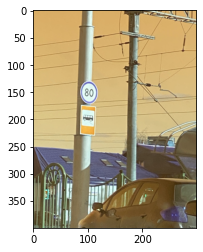

In [11]:
plt.imshow(im)

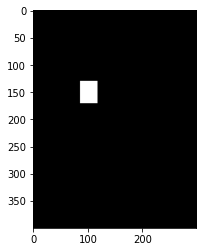

In [12]:
plt.imshow(Y, cmap='gray')

# Train-valid split


In [13]:
df_train = df_train.reset_index()
X = df_train[['new_path', 'new_bb']]
Y = df_train['class']

X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# Dataset

In [14]:
def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

In [ ]:
class RoadDataset(Dataset):
    def __init__(self, paths, bb, y):
        self.paths = paths.values
        self.bb = bb.values
        self.y = y.values
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        path = self.paths[idx]
        y_class = self.y[idx]
        x, y_bb = load_and_preprocess(path, self.bb[idx])
        x = normalize(x)
        x = np.rollaxis(x, 2)
        return x, y_class, y_bb
    
def load_and_preprocess(path, bb):
    x = cv2.imread(str(path)).astype(np.float32)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
    Y = create_mask(bb, x)
    return x, mask_to_bb(Y)

train_ds = RoadDataset(X_train['new_path'],X_train['new_bb'] ,y_train)
valid_ds = RoadDataset(X_val['new_path'],X_val['new_bb'],y_val)

batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

# Model

In [16]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

class BB_model(nn.Module):
    def __init__(self):
        super(BB_model, self).__init__()
        
        resnet = models.resnet34(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        self.bb = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        return self.classifier(x), self.bb(x)

# Training

In [17]:
def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = lr

def train_epocs(model, optimizer, train_dl, val_dl, epochs=10,C=1000):
    idx = 0
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for x, y_class, y_bb in train_dl:
            batch = y_class.shape[0]
            x = x.float()
            y_class = y_class
            y_bb = y_bb.float()
            out_class, out_bb = model(x)
            loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
            loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
            loss_bb = loss_bb.sum()
            loss = loss_class + loss_bb/C
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            idx += 1
            total += batch
            sum_loss += loss.item()
        train_loss = sum_loss/total
        val_loss, val_acc = val_metrics(model, valid_dl, C)
        print("train_loss %.3f val_loss %.3f val_acc %.3f" % (train_loss, val_loss, val_acc))
        
    return sum_loss/total

def val_metrics(model, valid_dl, C=1000):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    for x, y_class, y_bb in valid_dl:
        batch = y_class.shape[0]
        x = x.float()
        y_class = y_class
        y_bb = y_bb.float()
        out_class, out_bb = model(x)
        loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
        loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
        loss_bb = loss_bb.sum()
        loss = loss_class + loss_bb/C
        _, pred = torch.max(out_class, 1)
        correct += pred.eq(y_class).sum().item()
        sum_loss += loss.item()
        total += batch
    return sum_loss/total, correct/total

In [19]:
model = BB_model()
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.006)

train_epocs(model, optimizer, train_dl, valid_dl, epochs=15)

In [48]:
update_optimizer(optimizer, 0.001)
train_epocs(model, optimizer, train_dl, valid_dl, epochs=10)

# Making Preditcions

In [ ]:
# resizing test image
im = read_image('./road_signs/images_resized/road789.png')
im = cv2.resize(im, (int(1.49*300), 300))
cv2.imwrite('./road_signs/road_signs_test/road789.jpg', cv2.cvtColor(im, cv2.COLOR_RGB2BGR))

In [ ]:
# test Dataset
test_ds = RoadDataset(pd.DataFrame([{'path':'./road_signs/road_signs_test/road789.jpg'}])['path'],pd.DataFrame([{'bb':np.array([0,0,0,0])}])['bb'],pd.DataFrame([{'y':[0]}])['y'])
x, y_class, y_bb = test_ds[0]

In [ ]:
xx = torch.FloatTensor(x[None,])
xx.shape

In [ ]:
# prediction
out_class, out_bb = model(xx)
out_class, out_bb

In [ ]:
# predicted class
torch.max(out_class, 1)

In [ ]:
def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=3)

def show_corner_bb(im, bb):
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb))

# predicted bounding box
bb_hat = out_bb.detach().cpu().numpy()
bb_hat = bb_hat.astype(int)
show_corner_bb(im, bb_hat[0])